In [76]:
import numpy as np
from sklearn import datasets, neighbors, linear_model, tree
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

1. K-nearest neighbors classification
======================


Prepare dataset
--------------
First we will prepare the dataset. The dataset we choose is a modified  version of the [Iris dataset](https://archive.ics.uci.edu/ml/datasets/Iris). We choose only the first two input feature dimensions viz _sepal-length_ and _sepal-width_ (both in cm) for ease of visualization. 

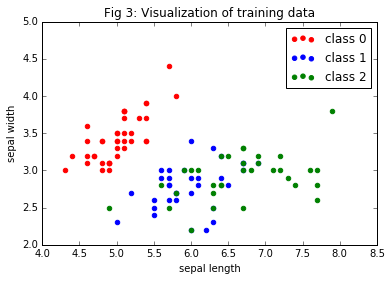

In [5]:
iris = datasets.load_iris()
X = iris.data[:,:2] #Choosing only the first two input-features
Y = iris.target

number_of_samples = len(Y)

#Splitting into training, validation and test sets
random_indices = np.random.permutation(number_of_samples)
#Training set
num_training_samples = int(number_of_samples*0.7)
x_train = X[random_indices[:num_training_samples]]
y_train = Y[random_indices[:num_training_samples]]
#Validation set
num_validation_samples = int(number_of_samples*0.15)
x_val = X[random_indices[num_training_samples : num_training_samples+num_validation_samples]]
y_val = Y[random_indices[num_training_samples: num_training_samples+num_validation_samples]]
#Test set
num_test_samples = int(number_of_samples*0.15)
x_test = X[random_indices[-num_test_samples:]]
y_test = Y[random_indices[-num_test_samples:]]

#Visualizing the training data
X_class0 = np.asmatrix([x_train[i] for i in range(len(x_train)) if y_train[i]==0]) #Picking only the first two classes
Y_class0 = np.zeros((X_class0.shape[0]),dtype=np.int)
X_class1 = np.asmatrix([x_train[i] for i in range(len(x_train)) if y_train[i]==1])
Y_class1 = np.ones((X_class1.shape[0]),dtype=np.int)
X_class2 = np.asmatrix([x_train[i] for i in range(len(x_train)) if y_train[i]==2])
Y_class2 = np.full((X_class2.shape[0]),fill_value=2,dtype=np.int)

plt.scatter(X_class0[:,0], X_class0[:,1],color='red')
plt.scatter(X_class1[:,0], X_class1[:,1],color='blue')
plt.scatter(X_class2[:,0], X_class2[:,1],color='green')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend(['class 0','class 1','class 2'])
plt.title('Fig 3: Visualization of training data')
plt.show()

Note that the first class is linearly separable from the other two classes but the second and third classes are not linearly separable from each other.

K-nearest neighbour classifier algorithm
--------------------
Now that our training data is ready we will jump right into the classification task. Just to remind you, the K-nearest neighbor is a non-parametric learning algorithm and does not learn an internal model for the training data. Instead it looks up the training set every time it is asked to classify a point and finds out the K nearest neighbors of the query point. The class corresponding to majority of the points is output as the class of the query point.

In [10]:
model = neighbors.KNeighborsClassifier(n_neighbors = 5) # K = 5
model.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Visualize the working of the algorithm
-------------------------------
Let's see how the algorithm works.
We choose the first point in the test set as our query point.

In [52]:
query_point = x_test[17]
true_class_of_query_point = y_test[17]
print "Query point: ", query_point
print "True class of query point: ", true_class_of_query_point

Query point:  [ 6.3  3.4]
True class of query point:  2


Let's visualize the point and its K=5 nearest neighbors.

The nearest neighbors of the query point are: 
[[ 6.3  3.3]
 [ 6.4  3.2]
 [ 6.4  3.2]
 [ 6.5  3.2]
 [ 6.   3.4]]
The classes of the nearest neighbors are: 
[1 2 1 2 1]
Predicted class for query point:  1


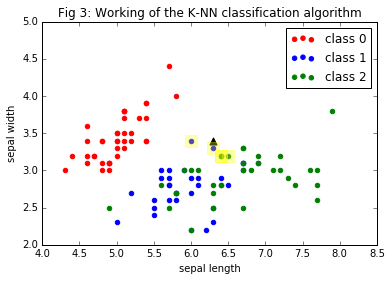

In [74]:
neighbors_object = neighbors.NearestNeighbors(n_neighbors=5)
neighbors_object.fit(x_train)
distances_of_nearest_neighbors, indices_of_nearest_neighbors_of_query_point = neighbors_object.kneighbors([query_point])
nearest_neighbors_of_query_point = x_train[indices_of_nearest_neighbors_of_query_point[0]]
print "The nearest neighbors of the query point are: \n", nearest_neighbors_of_query_point
print "The classes of the nearest neighbors are: \n",y_train[indices_of_nearest_neighbors_of_query_point[0]]
predicted_class_for_query_point = model.predict([query_point])
print "Predicted class for query point: ", predicted_class_for_query_point[0]

plt.scatter(X_class0[:,0], X_class0[:,1],color='red')
plt.scatter(X_class1[:,0], X_class1[:,1],color='blue')
plt.scatter(X_class2[:,0], X_class2[:,1],color='green')
plt.scatter(query_point[0], query_point[1],marker='^',s=50,color='black')
plt.scatter(nearest_neighbors_of_query_point[:,0], nearest_neighbors_of_query_point[:,1],marker='s',s=150,color='yellow',alpha=0.30)
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend(['class 0','class 1','class 2'])
plt.title('Fig 3: Working of the K-NN classification algorithm')
plt.show()

The black triangle is the query point. Its 5 nearest neighbors in the training set are marked with yellow boxes. (You can see just 4 of the points bacuse a couple of the class 1 points are overlapping in the feature-subspace we have chosen.) As class 1 is the majority class in the neighborhood of the query point, the classifier assigns class 1 to it.

Evaluate the performance of K-NN Classifier and compare with decision tree and logistic regression
--------------------------
Now we will check how K-NN performs alongside parameteric learning models - logistic regression and decision tree classifier that we discussed in the last class

In [90]:
#Define a K-NN classifier 
knn_ = neighbors.KNeighborsClassifier(n_neighbors=5)
knn_.fit(x_train,y_train)

#Define a logistic regression classifier
logistic_ = linear_model.LogisticRegression(C=1e5)
logistic_.fit(x_train,y_train)

#Define a decision tree classifier
decision_tree_ = tree.DecisionTreeClassifier()
decision_tree_.fit(x_train,y_train)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [95]:
def evaluate_performance(model, x_val, y_val, x_test, y_test):
    validation_set_predictions = [model.predict(x_val[i].reshape((1,len(x_val[i]))))[0] for i in range(x_val.shape[0])]
    validation_misclassification_percentage = 0
    for i in range(len(validation_set_predictions)):
        if validation_set_predictions[i]!=y_val[i]:
            validation_misclassification_percentage+=1
    validation_misclassification_percentage *= 100/len(y_val)
#     print 'validation misclassification percentage =', validation_misclassification_percentage, '%'

    test_set_predictions = [model.predict(x_test[i].reshape((1,len(x_test[i]))))[0] for i in range(x_test.shape[0])]

    test_misclassification_percentage = 0
    for i in range(len(test_set_predictions)):
        if test_set_predictions[i]!=y_test[i]:
            test_misclassification_percentage+=1
    test_misclassification_percentage *= 100/len(y_test)
#     print 'test misclassification percentage =', test_misclassification_percentage, '%'
    return validation_misclassification_percentage, test_misclassification_percentage

In [97]:
#Evaluate the performances on the validation and test sets
print "Evaluating K-NN classifier:"
val_err,test_err = evaluate_performance(knn_, x_val, y_val, x_test, y_test)
print 'validation misclassification percentage =', val_err, '%'
print 'test misclassification percentage =', test_err, '%'

print "\nEvaluating logistic regression classifier:"
val_err,test_err = evaluate_performance(logistic_, x_val, y_val, x_test, y_test)
print 'validation misclassification percentage =', val_err, '%'
print 'test misclassification percentage =', test_err, '%'

print "\nEvaluating decision tree classifier:"
val_err,test_err = evaluate_performance(decision_tree_, x_val, y_val, x_test, y_test)
print 'validation misclassification percentage =', val_err, '%'
print 'test misclassification percentage =', test_err, '%'

Evaluating K-NN classifier:
validation misclassification percentage = 24 %
test misclassification percentage = 28 %

Evaluating logistic regression classifier:
validation misclassification percentage = 36 %
test misclassification percentage = 8 %

Evaluating decision tree classifier:
validation misclassification percentage = 44 %
test misclassification percentage = 36 %


Variation of accuracy with increasing values of K
---------------------------------------
Now we will see how the accuracies change with the number of nearest neighbors chosen.


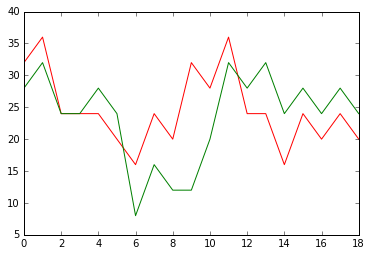

In [104]:
validation_error = []
test_error = []

for K in range(1,20):
    model = neighbors.KNeighborsClassifier(n_neighbors=K)
    model.fit(x_train,y_train)
    val_err,test_err = evaluate_performance(model,x_val,y_val,x_test,y_test)
    validation_error.append(val_err)
    test_error.append(test_err)

plt.figure()
plt.plot(validation_error,color='red')
plt.plot(test_error,color='green')
plt.show()

2. Principal Components Analysis
==========================


In this section we will use Principal Components Analysis for visualization of high dimensional data.

In [108]:
import pickle as pkl
with open('chosen_vectors.pkl','rb') as f:
    data = pkl.load(f)
    word_vectors = data['vectors']
projected_word_vectors = {}
pca_ = PCA(n_components=2)
pca_.fit([word_vectors[word] for word in word_vectors.keys()])
desired_words = ['man','woman','king','queen','london','britain','india','delhi','apple','orange']
for word in desired_words:
    projected_word_vectors[word] = pca_.transform([word_vectors[word]])[0]


In [110]:
print projected_word_vectors

{'king': array([-1.54884182,  1.1187226 ]), 'delhi': array([ 0.24505898,  1.30828627]), 'woman': array([-0.91586747,  0.44496269]), 'apple': array([-0.01413879, -1.80052337]), 'queen': array([-1.8746237 ,  0.20482741]), 'india': array([ 1.05841172,  0.77805937]), 'britain': array([ 0.45045949,  1.21593306]), 'london': array([-0.88920353,  0.30453175]), 'orange': array([-0.82066137, -1.05636473]), 'man': array([-1.09175045,  0.36508351])}


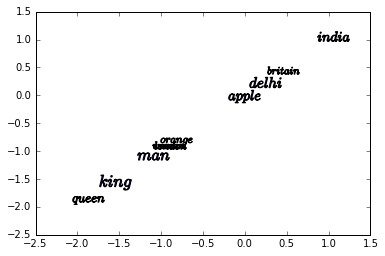

In [123]:
# just_vectors = np.asmatrix([projected_word_vectors[word] for word in projected_word_vectors.keys()])
# just_vectors.shape
plt.figure()
for word in projected_word_vectors:
    plt.scatter(projected_word_vectors[word][0], projected_word_vectors[word][0], s=1000, marker='$'+word+'$')
plt.show()